### packages

In [1]:
import os
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\CMD Research\\CMD Remote Repository\\autoencoder practice'

In [2]:
'''importing packages & necessary functions'''

# pytorch functionalities
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

# data processing
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# plotting & visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# others
import tqdm
import numpy as np
import webp
from IPython.display import clear_output

# gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### gather data

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '../../Local Data Files/MNIST'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)
# using the same data as testing since we are trying to reproduce the images
print(type(train_dataset))

# 80-20 train-val split
n_train = int(0.8*len(train_dataset))
n_val = len(train_dataset) - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val], generator=np.random.seed(0))
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}, Test dataset size: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].size()}")

# create train, validation and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

<class 'torchvision.datasets.mnist.MNIST'>
Train dataset size: 48000, Validation dataset size: 12000, Test dataset size: 60000
Image size: torch.Size([1, 28, 28])


### building architecture

##### notes

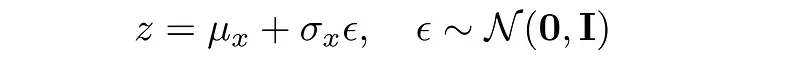

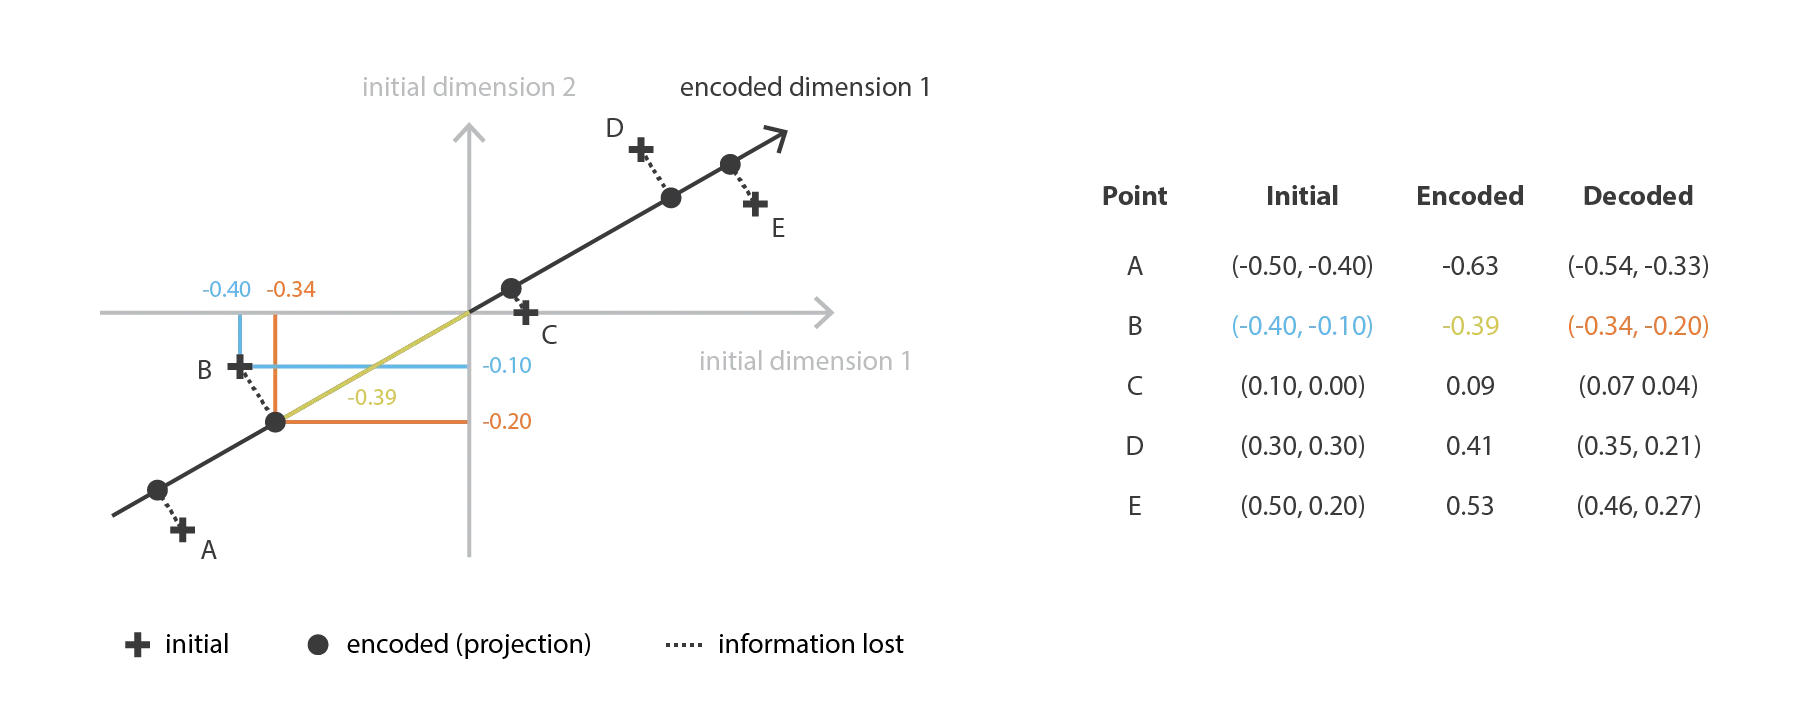

In [4]:
display(webp.load_image('../images/vae latent vector formula.webp'), 
        webp.load_image('../images/latent space visual.webp'))

##### model

In [5]:
# building the encoder class
class encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, latent_dim, leak=0.2, drop=0.5):
        super(encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(leak),
            nn.Dropout(drop),
            nn.Linear(hidden_dim, num_layers),
            nn.LeakyReLU(leak),
            nn.Dropout(drop)
            )
        
        # latent mean and covariance matrix (diagonal matrix of variances) 
        self.latent_mean = nn.Linear(num_layers, latent_dim)
        self.latent_variance = nn.Linear(num_layers, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mean, variance = self.latent_mean(x), self.latent_variance(x)
        return mean, variance

# building the decoder class
class decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, latent_dim, leak, drop):
        super(decoder, self).__init__()
    
        self.decoder = nn.Sequential(
                nn.Linear(latent_dim, num_layers),
                nn.LeakyReLU(leak),
                nn.Dropout(drop),
                nn.Linear(num_layers, hidden_dim),
                nn.LeakyReLU(leak),
                nn.Dropout(drop),
                nn.Linear(hidden_dim, input_dim), # output dimensions are the same as original inputs
                nn.Sigmoid()
                )

    def forward(self, x):
        return self.decoder(x)

# assembling the VAE class
class vae(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, latent_dim, leak, drop):
        super(vae, self).__init__()

        self.encoder = encoder(
                                input_dim=input_dim, 
                                hidden_dim=hidden_dim, 
                                num_layers=num_layers, 
                                latent_dim=latent_dim,
                                leak=leak, drop=drop
                            ).to(device)
        self.decoder = decoder(
                                input_dim=input_dim, 
                                hidden_dim=hidden_dim, 
                                num_layers=num_layers, 
                                latent_dim=latent_dim,
                                leak=leak, drop=drop
                            ).to(device)
    
    # sample z based on its latent space distribution
    def reparameterize(self, mean, variance):
        stdev = torch.randn_like(variance).to(device)
        return mean + variance*stdev # <-- z reparameterized

    def forward(self, x):
        x = x.to(device)
        mean, variance = self.encoder(x)
        z_sample = self.reparameterize(mean, variance)
        z = self.decoder(z_sample) # reconstruct the original input
        return z, mean, variance


### initialize & train

##### training, loss, evaluation functions

###### notes

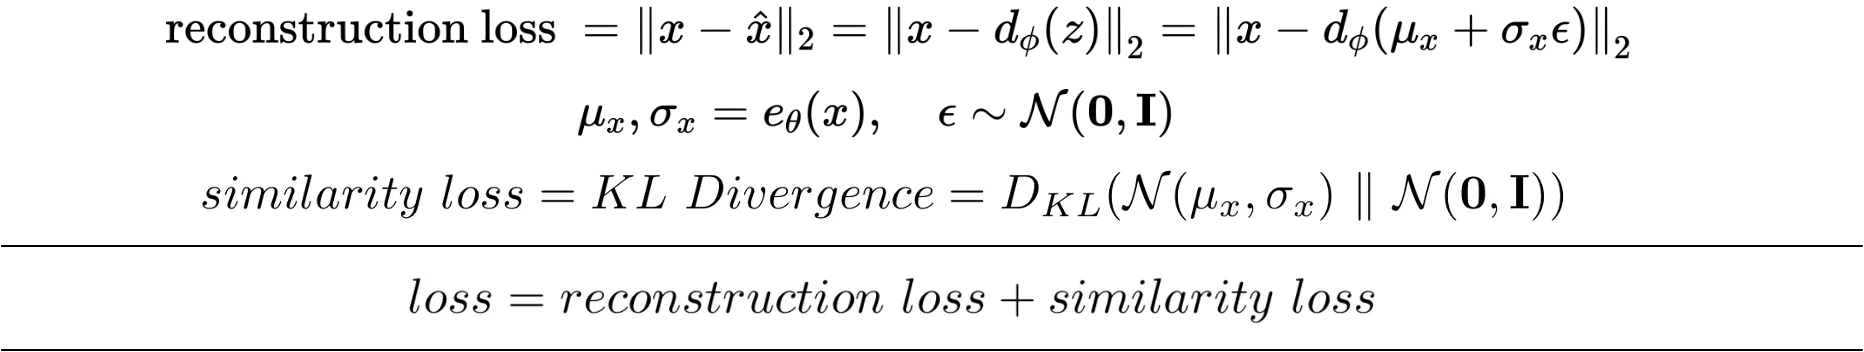

In [6]:
display(webp.load_image('../images/loss explained.webp'))

###### define

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # loss = reconstruction loss + similarity loss (KL divergence)
    return reproduction_loss + KLD

In [8]:
def train(model, optimizer, epochs, loss_list, val_list, x_dim):

    for epoch in tqdm.trange(epochs):
        model.train()
        for x, _ in train_loader:
            loss_ct = 0
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            outputs, mean, log_var = model(x)
            loss = loss_function(x, outputs, mean, log_var)
            
            loss.backward()
            loss_ct += loss.item()
            avg_loss = loss_ct / len(train_loader)
            loss_list.append(avg_loss)
            optimizer.step()
        
        # validation accuracy -------------------------------------------------
        model.eval()
        with torch.no_grad():

            loss_ct = 0
            for x, _ in val_loader:
                x = x.view(batch_size, x_dim).to(device)
                outputs, mean, log_var = model(x)

                loss = loss_function(x, outputs, mean, log_var)
                loss_ct += loss.item()

                # correct = (torch.argmax(outputs, dim=1).to(device) == torch.argmax(x, dim=1)).type(torch.FloatTensor)
                # val_list.append(correct.mean())

            avg_loss = loss_ct / len(val_loader)
            val_list.append(avg_loss)
            

        # Plot losses and validation accuracy in real-time ---------------------
        if epoch > 0:
            fig, ax = plt.subplots(figsize=(12, 5))
            clear_output(wait=True)

            ax.clear()
            ax.plot(loss_list, label='Training Loss', linewidth = 3, color = 'blue')
            ax.plot([i*len(train_loader) for i in range(epoch+1)], val_list, label='Validation Loss', linewidth = 3, color = 'gold')
            ax.legend(title=f'Lowest Loss: {min(loss_list):.3f} \nAverage Loss: {np.mean(loss_list):.3f}', bbox_to_anchor=(1, 1), loc='upper left')
            ax.set_title('Training Performance')
            ax.set_ylabel("Loss")
            plt.show()

In [9]:
def plot_latent(model, data, num_batches=batch_size):
    for i, (x, y) in enumerate(data):
        x = x.view(x.size(0), -1).to(device)
        z, _ = model.encoder(x)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

def plot_reconstructed(model, rangex=(-5, 10), rangey=(-10, 5), n=12):
    '''
    range in the latent space to generate:
        rangex = range of x values
        rangey = range of y values

    n = number of images to plot
    '''
    w = train_dataset[0][0].size()[1] # image width
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*rangey, n)):
        for j, x in enumerate(np.linspace(*rangex, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*rangex, *rangey])

##### initialize & train

In [10]:
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}, Test dataset size: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].size()}")

# compressed image size: 28x28 = 784
img_size = train_dataset[0][0].size()[1]*train_dataset[0][0].size()[2] 
print(f"Compressed Image Size: {img_size}")

Train dataset size: 48000, Validation dataset size: 12000, Test dataset size: 60000
Image size: torch.Size([1, 28, 28])
Compressed Image Size: 784


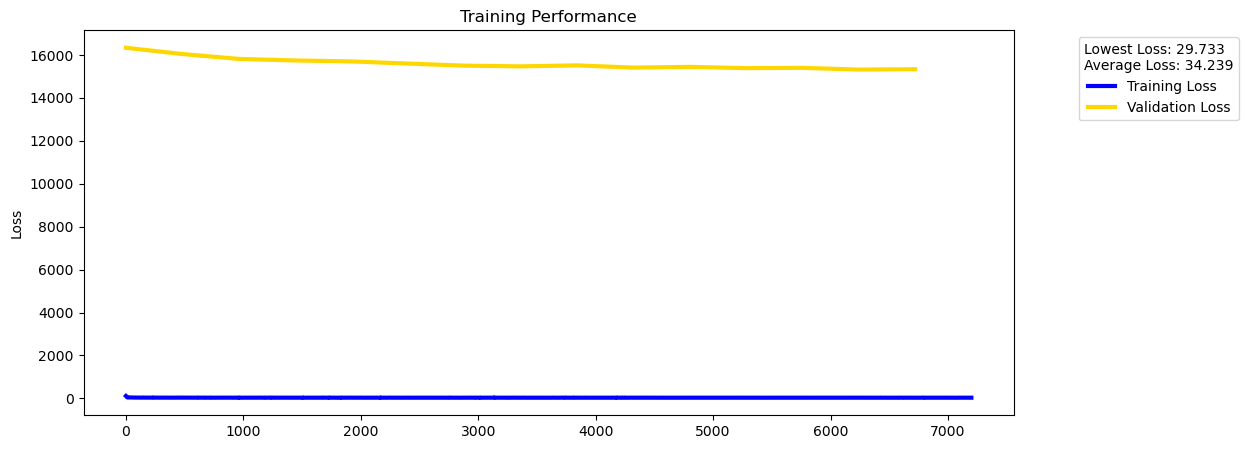

100%|██████████| 15/15 [01:44<00:00,  6.97s/it]


In [11]:
model = vae(
        input_dim=img_size, 
        hidden_dim=512, 
        num_layers=392, 
        latent_dim=2,
        leak=0.2, drop=0.5
    ).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
validation, losses = [], []
train(model, optimizer, epochs=15, 
      loss_list=losses, val_list=validation, x_dim=img_size
    )

### visualize performance

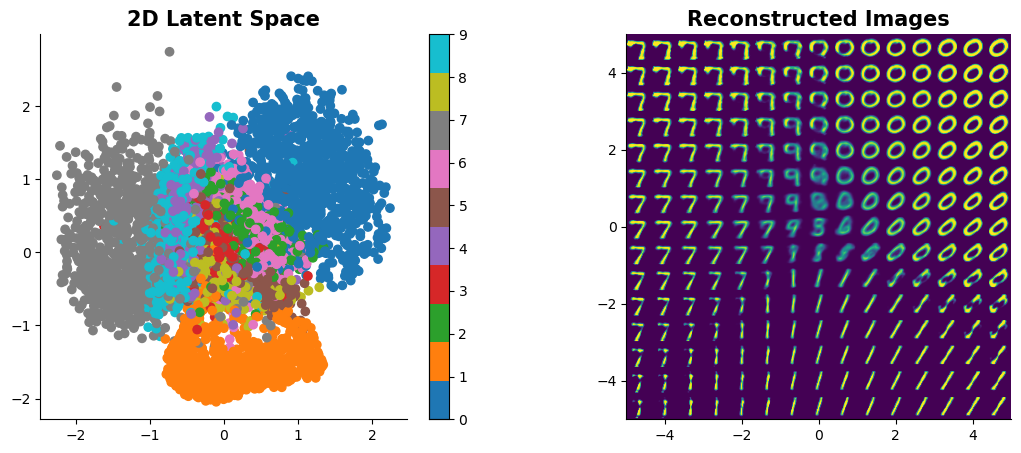

In [12]:
plt.figure(figsize = (13, 5))

plt.subplot(1, 2, 1)
plt.title("2D Latent Space", fontsize = 15, fontweight = 'bold')
plot_latent(model, train_loader, num_batches=batch_size) 
sns.despine()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Images", fontsize = 15, fontweight = 'bold')
plot_reconstructed(model, n=15, rangex=(-5, 5), rangey=(-5, 5))
sns.despine()